In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from football_sim import *
plt.rcParams['figure.figsize']=[16,9]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv'
                          }


In [15]:
all_data=get_data(urls)
all_data['EN']=add_match(all_data['EN'],'Liverpool',4,'West Ham',1)
all_data['EN']=add_match(all_data['EN'],'Crystal Palace',0,'Tottenham',1)
all_data['EN']=add_match(all_data['EN'],'Man United',2,'Chelsea',1)
all_data['EN'].tail(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
268,2018-11-02,Southampton,Liverpool,0,2
269,2018-12-02,Chelsea,West Brom,3,0
270,2018-02-25,Liverpool,West Ham,4,1
271,2018-02-25,Crystal Palace,Tottenham,0,1
272,2018-02-25,Man United,Chelsea,2,1


In [4]:
#all_data['EN']=add_match(all_data['EN'],'Chelsea',1,'West Brom',0)
all_data['EN'].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
260,2018-10-02,Everton,Crystal Palace,3,1
261,2018-10-02,Man City,Leicester,5,1
262,2018-10-02,Stoke,Brighton,1,1
263,2018-10-02,Swansea,Burnley,1,0
264,2018-10-02,Tottenham,Arsenal,1,0
265,2018-10-02,West Ham,Watford,2,0
266,2018-11-02,Huddersfield,Bournemouth,4,1
267,2018-11-02,Newcastle,Man United,1,0
268,2018-11-02,Southampton,Liverpool,0,2
269,2018-12-02,Chelsea,West Brom,3,0


In [16]:
teams = create_teams(all_data)

In [17]:
teams=calibrate(teams,all_data)

In [18]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

In [19]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,98.9,93.0,105.0,1.0,1.0,100.0,100.00,2.36,0.19,0.00
Liverpool,79.7,74.0,85.0,4.0,2.0,0.0,97.22,1.71,0.26,0.00
Man United,78.5,72.0,84.0,5.0,2.0,0.0,94.92,1.22,0.15,0.00
Tottenham,75.7,70.0,81.0,5.0,2.0,0.0,81.96,1.30,0.16,0.00
Chelsea,71.1,65.0,77.0,6.0,3.0,0.0,24.48,1.13,0.22,0.00
Arsenal,64.6,58.0,71.0,6.0,5.0,0.0,1.41,1.27,0.56,0.00
Burnley,52.7,46.0,59.0,10.0,7.0,0.0,0.00,0.32,0.18,0.00
Leicester,52.7,46.0,60.0,10.0,7.0,0.0,0.00,0.87,0.60,0.00
Everton,46.4,40.0,53.0,14.0,8.0,0.0,0.00,0.54,0.91,0.31
Watford,43.4,37.0,50.0,16.0,8.0,0.0,0.00,0.85,0.94,1.87


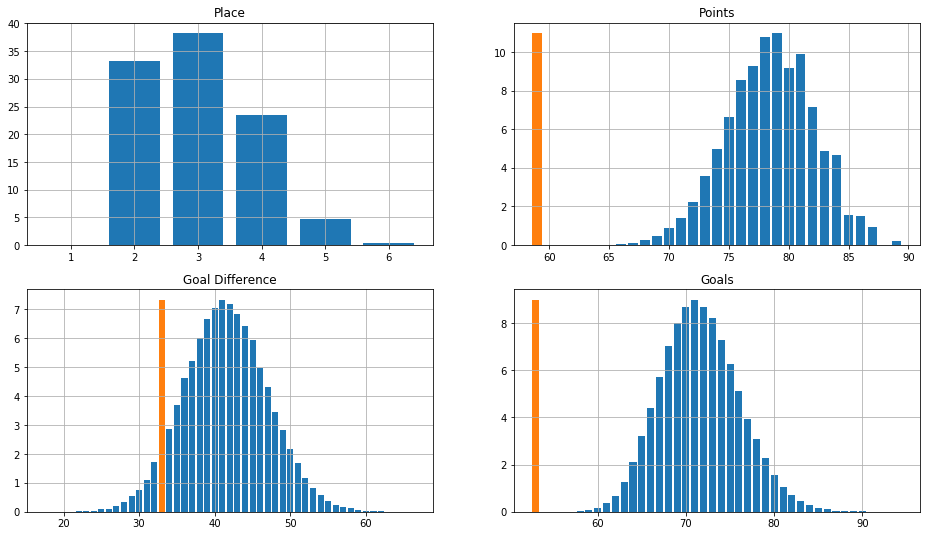

In [20]:
PremierLeague.team_report('Man United')

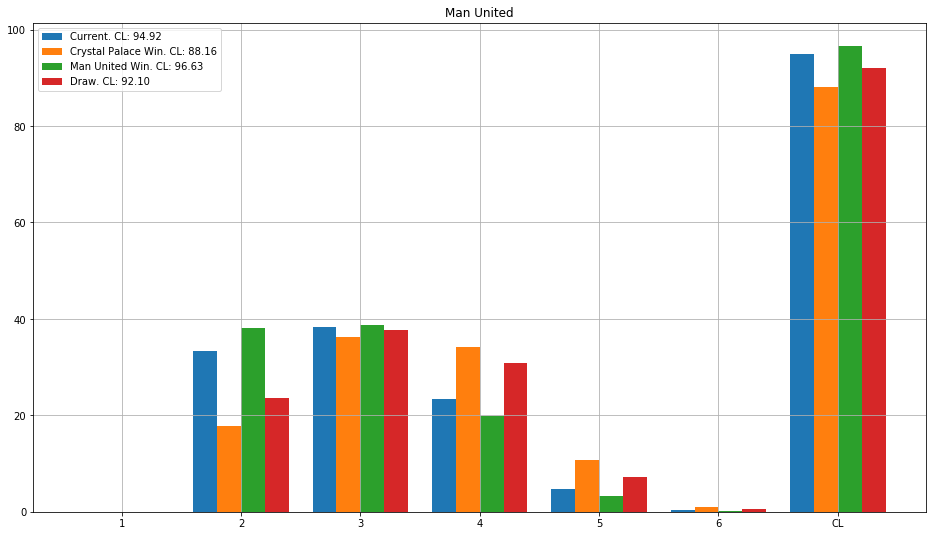

In [22]:
PremierLeague.what_if('Crystal Palace v Man United',ref_team='Man United')

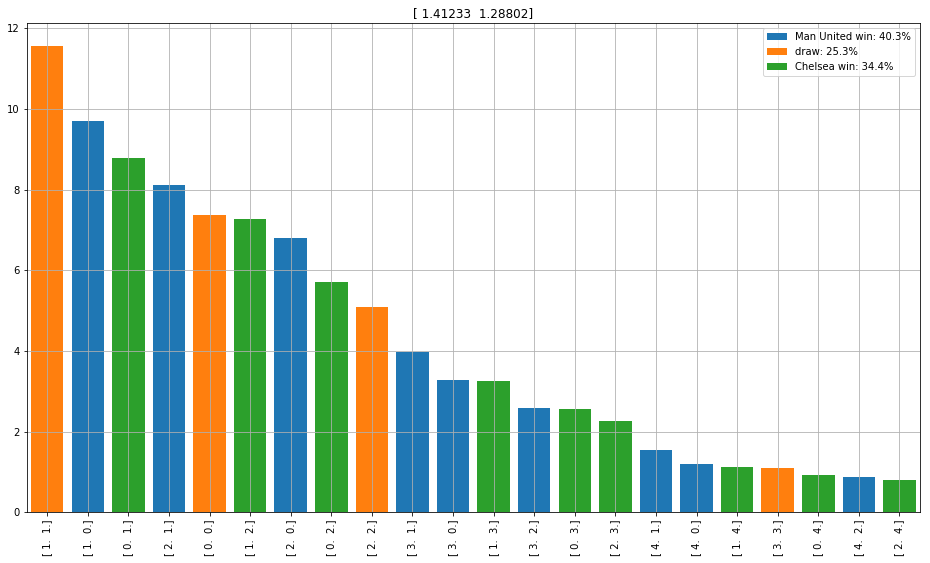

In [14]:
teams['Man United']+teams['Chelsea']

In [13]:
TeamSet={x:teams[x] for x in teams if teams[x].means()[0]>=1 and teams[x].country=='EN'}
#GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1.2}

In [14]:
CustomLeague=Season(TeamSet,nr_cl=2,nr_degr=1)
CustomLeague.process_current_results(all_data['EN'])
CustomLeague.process_current_results(all_data['ES'])
CustomLeague.process_current_results(all_data['DE'])
CustomLeague.process_current_results(all_data['NL'])
CustomLeague.process_current_results(all_data['FR'])
CustomLeague.process_current_results(all_data['IT'])
CustomLeague.simulate_season(n_scenarios=100000)

KeyError: 'DE'

In [ ]:
CustomLeague.team_report('Man United')

In [ ]:
CustomLeague.team_report('Man City')

In [ ]:
CustomLeague.season_report()

In [ ]:
SpanishTeams={x:teams[x] for x in teams if teams[x].country=='ES'}
LaLiga=Season(SpanishTeams)
LaLiga.process_current_results(all_data['ES'])
LaLiga.simulate_season(n_scenarios=100000)

In [ ]:
LaLiga.season_report()

In [ ]:
LaLiga.team_report('Real Madrid')

In [ ]:
LaLiga.team_report('Barcelona')